In [173]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time
%matplotlib inline

In [174]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [175]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10


In [176]:
print('STEP 1: DEFINE DATASET')

train_dataset = dset.MNIST("./data/mnist", train=True, target_transform=None,
                            download=True, transform=transforms.Compose([
                            transforms.RandomCrop((40,40),padding=4, pad_if_needed=True),
                            transforms.Pad((20, 20)),
                            transforms.RandomAffine(degrees=(-45, 45) ,translate=(0.25,0.25), scale=(0.7, 1.2)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))]))

test_dataset = dset.MNIST("./data/mnist", train=False, target_transform=None,
                        transform=transforms.Compose([
                        transforms.RandomCrop((40,40),padding=4, pad_if_needed=True),
                        transforms.Pad((20, 20)),
                        transforms.RandomAffine(degrees=(-45, 45) ,translate=(0.25,0.25), scale=(0.7, 1.2)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]),
                        download=False)


train_size = len(train_dataset)
test_size = len(test_dataset)
print(train_dataset)
#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

STEP 1: DEFINE DATASET
Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data/mnist
    Transforms (if any): Compose(
                             RandomCrop(size=(40, 40), padding=4)
                             Pad(padding=(20, 20), fill=0, padding_mode=constant)
                             RandomAffine(degrees=(-45, 45), translate=(0.25, 0.25), scale=(0.7, 1.2))
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None
MNIST mean:  tensor(0.1307)
MNIST std:  tensor(0.3081)


In [177]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))


Train dataset size: 60000
Test dataset size: 10000


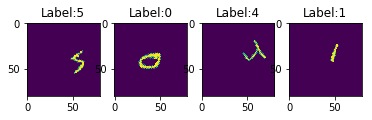

In [179]:

figure = plt.figure()

for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,4,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2)
    if i == 3:
        plt.show()
        break

In [180]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

STEP 2: LOADING DATASET


In [181]:
print('STEP 3: CREATE MODEL CLASS (STN_CNN)')


class STN_CNN(nn.Module):
    def __init__(self):
        super(STN_CNN, self).__init__()
        #make cnn layer
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 9, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 7, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        #make classifier layer
        self.fc = nn.Sequential(
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        #make localization network layer
        self.localization = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 20, 5, 1),
            nn.ReLU()
        )

        #make fc_local layer(regression layer)
        self.fc_local = nn.Sequential(
            nn.Linear(23120, 20),
            nn.ReLU(),
            nn.Linear(20, 3 * 2)
        )
        # initialize the fc_local layer to Identity matrix
        self.fc_local[2].weight.data.zero_()
        self.fc_local[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        # forwarding stn module
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(xs.size(0), -1)
        theta = self.fc_local(xs)
        # arrange list to matrix
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        x = F.avg_pool2d(x, 2)

        return x
        
        # forward entire module 
    def forward(self, x):
        x = self.stn(x)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
#############
#############
#############




STEP 3: CREATE MODEL CLASS (STN_CNN)


In [182]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

STN_CNN's state_dict:
conv.0.weight 	 torch.Size([32, 1, 9, 9])
conv.0.bias 	 torch.Size([32])
conv.3.weight 	 torch.Size([64, 32, 7, 7])
conv.3.bias 	 torch.Size([64])
fc.0.weight 	 torch.Size([128, 1600])
fc.0.bias 	 torch.Size([128])
fc.2.weight 	 torch.Size([10, 128])
fc.2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.3.weight 	 torch.Size([20, 20, 5, 5])
localization.3.bias 	 torch.Size([20])
fc_local.0.weight 	 torch.Size([20, 23120])
fc_local.0.bias 	 torch.Size([20])
fc_local.2.weight 	 torch.Size([6, 20])
fc_local.2.bias 	 torch.Size([6])


In [74]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


In [75]:
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
criterion = nn.CrossEntropyLoss()
#############

# Model to GPU
model.train()
model.to(device0)


print('STEP 7: TRAIN THE MODEL')
best_acc = 0
TotalTime = 0
for epoch in range(num_epoch):
    #TRAIN
    start = time.time()
    correct = 0
    total = 0
    for j,(img,labels) in enumerate(train_loader):
        
        #############
        img = img.to(device0)
        labels = labels.to(device0)
        
        optimizer.zero_grad()
        
        outputs = model(img)   
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        #############
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()

        accuracy = 100 * correct.item() / total
        
        
        if j % 200 == 0:
            print('training accuracy : {}/{} ({:02f}%)'.format(correct, total, accuracy))
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    correct = 0
    total = 0
    #############
    with torch.no_grad():
        for imgs, label in test_loader:


            imgs = imgs.to(device0)
            label = label.to(device0)
            # Forward pass only to get logits/output
            outputs = model(imgs)
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels

            total += label.size(0)

            if torch.cuda.is_available():
                correct += (predicted.cpu() == label.cpu()).sum()
            else:
                correct += (predicted == label).sum()

        accuracy = 100 * correct.item() / total
        print('test accuracy : {}/{} ({:02f}%)'.format(correct, total, accuracy))
        #############
    TIME = time.time() - start
    print('////Epoch elapsed time: {}////\n'.format(TIME))
    TotalTime += TIME
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './pretrain/lab5/best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)
averagetime = TotalTime/(epoch+1)
print(averagetime)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


training accuracy : 33/256 (12.890625%)
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.301899  
training accuracy : 21834/51456 (42.432369%)
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.907038  
test accuracy : 7774/9984 (77.864583%)
////Epoch elapsed time: 9.194650650024414////

training accuracy : 200/256 (78.125000%)
Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.661528  
training accuracy : 43771/51456 (85.064910%)
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.335548  
test accuracy : 9018/9984 (90.324519%)
////Epoch elapsed time: 8.880147218704224////

training accuracy : 231/256 (90.234375%)
Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.296009  
training accuracy : 46873/51456 (91.093361%)
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.244456  
test accuracy : 9209/9984 (92.237580%)
////Epoch elapsed time: 8.90465497970581////

training accuracy : 237/256 (92.578125%)
Train Epoch: 3 [0/6000

##### 

In [183]:
model = STN_CNN()
checkpoint = torch.load('./pretrain/lab5/best_model_STN.tar')
model.load_state_dict(checkpoint['model_state_dict'])



<All keys matched successfully>

In [184]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])
print('Best epoch', checkpoint['epoch'])

Best accuracy of our model with ST module:  98.97836538461539
Best epoch 53


In [185]:
# Tensor image to array image

def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    img_re = img_re.transpose(1,2,0)
    
    return img_re


In [186]:

class VisualizeSTN():
    
    def __init__(self, model):
        self.model = model
        self.model.to(device0)
        self.model.eval()
    
    # hook the output at end of stn module
    def forward_stn(self,x):
        #############
        x = self.model.stn(x)
        
        return x
        #############
    
    def visualize(self, img):
        #############
        # hook the output at end of stn module
        img_stn = self.forward_stn(img)
        # make original data image grid & transformed image
        input_grid = reprocess_image(
            torchvision.utils.make_grid(img, nrow=4))
        output_grid = reprocess_image(
            torchvision.utils.make_grid(img_stn,nrow=4))
        # show grid image input & output
        f, graph = plt.subplots(1, 2)
        graph[0].imshow(input_grid)
        graph[0].set_title('Dataset Images')

        graph[1].imshow(output_grid)
        graph[1].set_title('Spatial Transformed Images')
        #############
        
        

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


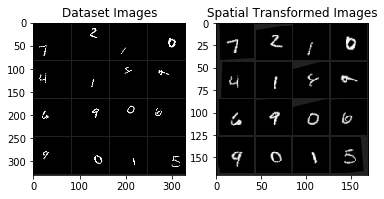

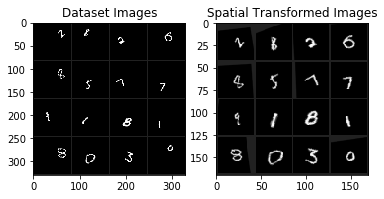

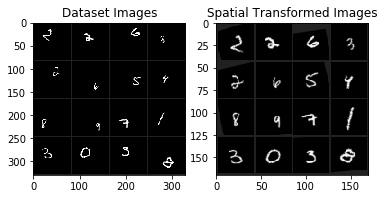

In [187]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    
    img = image[:16].to(device0)
    visualize_stn.visualize(img)
    
    if (i+1) == 3:
        break


In [170]:
#############
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 9, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 7, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1600,128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = F.avg_pool2d(x, 2)
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
#############


In [171]:
model_nostn = CNN()

print("CNN's state_dict:")
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())

CNN's state_dict:
cnn.0.weight 	 torch.Size([32, 1, 9, 9])
cnn.0.bias 	 torch.Size([32])
cnn.3.weight 	 torch.Size([64, 32, 7, 7])
cnn.3.bias 	 torch.Size([64])
fc.0.weight 	 torch.Size([128, 1600])
fc.0.bias 	 torch.Size([128])
fc.2.weight 	 torch.Size([10, 128])
fc.2.bias 	 torch.Size([10])


In [169]:
optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [65]:
#############
criterion = nn.CrossEntropyLoss()
#############

# Model to GPU
model_nostn.train()
model_nostn.to(device0)
TotalTime = 0
best_acc = 0
for epoch in range(num_epoch):
    start = time.time()

    for j, (img, label) in enumerate(train_loader):
        img = img.to(device0)
        label = label.to(device0)
        
        optimizer.zero_grad()
        
        output = model_nostn(img)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        
        if j % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    model_nostn.eval()
    correct = 0
    total = 0
    #############
    with torch.no_grad():
        for img, label in test_loader:


            img = img.to(device0)
            label = label.to(device0)
            # Forward pass only to get logits/output
            outputs = model_nostn(img)
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels

            total += label.size(0)

            if torch.cuda.is_available():
                correct += (predicted.cpu() == label.cpu()).sum()
            else:
                correct += (predicted == label).sum()

        accuracy = 100 * correct.item() / total
        print('test accuracy : {}/{} ({:02f}%)'.format(correct, total, accuracy))
        #############
    IME = time.time() - start
    print('////Epoch elapsed time: {}////\n'.format(TIME))
    TotalTime += TIME
    
    if accuracy > best_acc :
        best_acc = accuracy
    
    scheduler.step(accuracy)
averagetime = TotalTime/(epoch+1)
print(averagetime)
#############

Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:0.277105  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.269346  
test accuracy : 9262/9984 (92.768429%)
////Epoch elapsed time: 8.89002251625061////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.248381  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.205444  
test accuracy : 9220/9984 (92.347756%)
////Epoch elapsed time: 8.89002251625061////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.241102  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.178641  
test accuracy : 9273/9984 (92.878606%)
////Epoch elapsed time: 8.89002251625061////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.310890  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.231548  
test accuracy : 9393/9984 (94.080529%)
////Epoch elapsed time: 8.89002251625061////

Train Epoch: 4 [0/60000 (0%) / Learning rate:0.001]	Loss:0.211803  
Train Epoch: 4 [51200/60000 

In [19]:
print('Best accuracy of our model without ST module: ', best_acc)

Best accuracy of our model without ST module:  96.90504807692308


### Discussion & Analysis
> Structure 
>> transform dataset : dataset을 transform 하기 위해서 torchvision에 모든 module을 살펴보았다. 문제점은 translate을 하는 시점이었는데 padding을 하여 이미지 size를 두 배로 늘리기 전에 translate을 하면 digit이 잘리는 상황이 발생하였다. 그래서 Randomcrop과 Resize 둘 중 하나를 하여 40 x 40으로 만들어 줬어야 했는데 결과를 확인해보니 Randomcrop이 sample image 같은 형식으로 나와서 Randomcrop을 통해 이미지를 transform하였다.
>> <sample><figcaption>sample image</figcaption> <img src="https://drive.google.com/uc?id=14QNbInNEeT4AQplcCcKmQ3zfeDy155e5" alt="no_image" width="300" height="150"/></sample> 
>> <randomcrop><figcaption>Randomcrop image</figcaption> <img src="https://drive.google.com/uc?id=1rU4x2dF2OibG8UBg4VvF1ozXlFqKIvd-" alt="no_image" width="300" height="150"/></randomcrop>
>> <resize><figcaption>resize image</figcaption><img src="https://drive.google.com/uc?id=1iEP_dx4VWibz7PMtykzM9qIf9uEriDOQ" alt="no_image" width="300" height="150"/></resize>

>> STN network : feature수를 주어진 sample에 맞게 작성하기 위해서 차원을 계산하여 maxpooling layer와 average pooling layer의 위치를 결정하였다. grid를 만드는 부분을 작성하기 위해서 pytorch tutorial 중 하나인 stn module을 참고하였다. 그 부분 제외하고는 큰 어려움이 없었다.

>> Visualize image : 이해보다 코드를 작성하여보니 생각보다 오류없이 크게 실행된 부분이다. make_grid의 nrow=4로 한 부분만 조금 고민하였다.
>> CNN without STN : Resnet과 Vggnet 작성을 해봐서 큰 어려움이 없었다.

> Compare with image of CNN without STN 
>> 실행속도를 비교하면 10 epoch동안 elapsed time/epoch는 CNN with STN : 8.878sec 이며, CNN without STN은 : 8.890sec였다. 실제로 STN 모듈이 추가되었다고 하여 수행시간에 영향을 거의 안준다는 것을 확인할 수 있었다. 또한 성능을 비교하면 60epoch 기준으로 Best accuracy of our model with ST module:  98.85817307692308% 이였고 Best accuracy of our model without ST module:  96.90504807692308%이므로 실제로 성능이 개선이 되었다는 점도 알 수 있었다.

>> 그러나 Visualize transformed image를 확인해보면 숫자들이 사람이 확인하여도 더욱 식별하기 좋게 transformed된 것을 확인할 수 있으나 rotation은 크게 되지 않았다. 아마 이러한 부분은 CNN이 학습하기에 rotation되는 것은 digit을 확인하기에는 큰 factor가 아닐 것이어서 STN이 rotation하는 것을 학습하지 않았다고 생각할 수 있었다.
>> + test loader가 10000개의 data를 불러오지 않는 부분이 의문이었으나 drop_last = True인 것을 확인하고 수정하지 않았다.